In [1]:
from pathlib import Path
import re

import matplotlib.pyplot as plt
import mne
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats
from tqdm.notebook import tqdm

basedir = Path("..").resolve()
import sys
sys.path.append(str(basedir))

DATA_DIR = Path("/om/data/public/language-eeg/frank2015")

EPOCH_WINDOW = (-0.1, 0.6)
TEST_WINDOW = (0.3, 0.5)
BASELINE_WINDOW = (None, 0)

N400_ELECTRODES = ["1", "14", "24", "25", "26", "29", "30", "31", "41", "42", "44", "45"]

Matplotlib created a temporary config/cache directory at /tmp/matplotlib-cp_bopzc because the default path (/home/jovyan/.cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


In [2]:
from mfn400.adapters.frank2015 import FrankDatasetAdapter

In [3]:
data = FrankDatasetAdapter(DATA_DIR, basedir / "output/frank2015/stim_df.csv")

In [4]:
for subject_idx in tqdm(data._raw_data.keys()):
    presentation_df = data.get_presentation_data(subject_idx)
    # Compute description / event ID again
    presentation_df["description"] = (presentation_df.word_idx == 0) * presentation_df.sentence_idx + (presentation_df.word_idx + 1)

    # Compute surprisal tertiles
    tertile_labels = ["low", "mid", "high"]
    presentation_df["surprisal_tertile"] = pd.qcut(presentation_df.surprisal, 3, labels=tertile_labels)

    # HACK: Update annotation descriptions to pick out surprisal tertile
    annots = data._raw_data[subject_idx].annotations
    annot_idxs = [idx for idx in range(len(annots)) if not annots.description[idx].startswith(("BAD", "EDGE"))]
    assert len(annot_idxs) == len(presentation_df)
    for annot_idx, (_, row) in zip(annot_idxs, presentation_df.iterrows()):
        annots.description[annot_idx] = row.surprisal_tertile

  0%|          | 0/24 [00:00<?, ?it/s]

In [5]:
epochs = data.to_epochs(EPOCH_WINDOW)

In [6]:
keep_conditions = ["low", "high"]
all_dfs = pd.concat([e[keep_conditions].to_data_frame() for e in tqdm(epochs.values())],
                    names=["subject"], keys=epochs.keys())

  0%|          | 0/24 [00:00<?, ?it/s]

In [164]:
id_vars = ["subject", "epoch", "time", "condition"]
plot_data = all_dfs.reset_index()[id_vars + N400_ELECTRODES[:2]] \
    .melt(id_vars=id_vars, var_name="electrode")

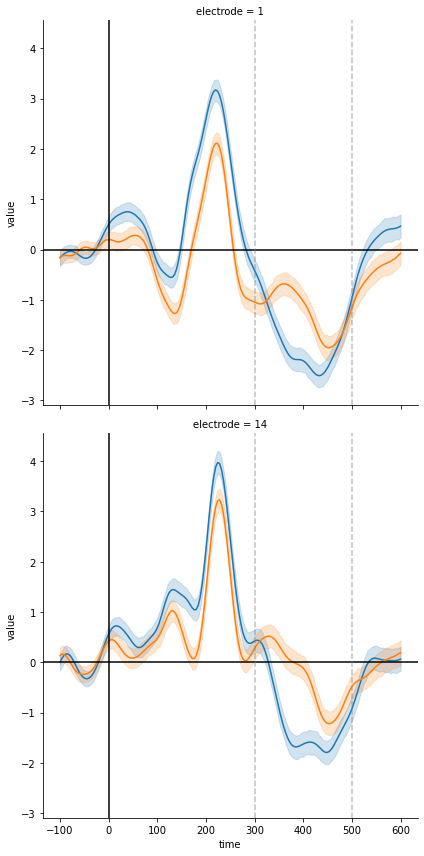

In [165]:
g = sns.FacetGrid(data=plot_data, row="electrode", height=6)
g.map(sns.lineplot, "time", "value", "condition")

for ax in g.axes.flat:
    ax.axhline(0, color="black")
    ax.axvline(0, color="black")
    ax.axvline(300, color="gray", alpha=0.5, linestyle="--")
    ax.axvline(500, color="gray", alpha=0.5, linestyle="--")
    
g.savefig("frank2015_fig3.png")

## Quantitative evaluation

### Electrode ranking by surprisal effect magnitude

For each electrode, compute maximum (over time) mean (over item) difference in response between low- and high-surprisal items within the test window.
Rank electrodes by their maximum difference.

Then compare this ranking to the ranking of surprisal predictor effect size in CDRNN IRFs.

In [78]:
electrode_tertile_response_diffs = plot_data[(plot_data.time > TEST_WINDOW[0] * 1000) & (plot_data.time <= TEST_WINDOW[1] * 1000)] \
    .groupby(["electrode", "subject", "time"]).apply(
        lambda g: g.pivot("epoch", "condition", "value").mean(axis=0).sort_index().diff().iloc[-1]
    ).groupby(["electrode", "subject"]).apply(
        lambda g: pd.Series((g.idxmax()[-1], g.max()), index=["time", "diff"])).unstack()

In [79]:
electrode_tertile_response_diffs

time      diff
electrode subject                 
1         1        368.0  2.435011
          10       424.0  0.942012
          11       492.0  2.118374
          12       424.0  1.882055
          13       328.0  1.162657
...                  ...       ...
45        5        376.0  1.281335
          6        500.0  2.805318
          7        488.0  0.570589
          8        348.0  1.661391
          9        360.0  1.912127

[288 rows x 2 columns]

<AxesSubplot:xlabel='electrode', ylabel='diff'>

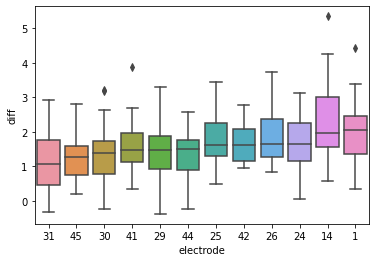

In [86]:
sns.boxplot(data=electrode_tertile_response_diffs.reset_index(), x="electrode", y="diff",
            order=electrode_tertile_response_diffs.groupby("electrode")["diff"].median().sort_values().index)

In [95]:
electrode_ranks = electrode_tertile_response_diffs.groupby("electrode")["diff"].mean().sort_values()

#### CDRNN comparison

In [138]:
cdrnn_fit_dirs = [Path(x) for x in
                  ["../work/1b/ac98e068a48fa17f55694e73276cd4/CDR_full",
                   "../work/ec/049b490b0c49a30f5c87d376b82c93/CDR_full",
                   "../work/c3/530f9409b6f67a961b7fa48c0f7f52/CDR_full"]]
cdrnn_irf_csvs = [x for fit_dir in cdrnn_fit_dirs
                  for x in fit_dir.glob("CDR_full*irf_*.csv")]

file_re = re.compile(r"work/(../..).+/CDR_.*_(?:el)?(\d+)\.csv")
names = ["run", "electrode"]
keys = [file_re.findall(str(p))[0] for p in cdrnn_irf_csvs]

cdrnn_irf_df = pd.concat([pd.read_csv(path) for path in cdrnn_irf_csvs],
                         names=names, keys=keys).droplevel(-1)
cdrnn_irf_df

time      Rate  surprisal  word_freq    RateLB  \
run   electrode                                                       
1b/ac 14         0.000000 -0.066252   0.038527  -0.018123 -0.066252   
      14         0.004888 -0.071191   0.040388  -0.020221 -0.071191   
      14         0.009775 -0.076243   0.042242  -0.022366 -0.076243   
      14         0.014663 -0.081404   0.044086  -0.024554 -0.081404   
      14         0.019550 -0.086671   0.045917  -0.026786 -0.086671   
...                   ...       ...        ...        ...       ...   
ec/04 45         4.980450  0.246094  -0.019922  -0.017331  0.246094   
      45         4.985337  0.246572  -0.020106  -0.017539  0.246572   
      45         4.990225  0.247049  -0.020288  -0.017746  0.247049   
      45         4.995112  0.247526  -0.020471  -0.017951  0.247526   
      45         5.000000  0.248003  -0.020653  -0.018157  0.248003   

                 surprisalLB  word_freqLB    RateUB  surprisalUB  word_freqUB  
run   electrode                                                                
1b/ac 14            0.038527    -0.018123 -0.066252     0.038527    -0.018123  
      14            0.040388    -0.020221 -0.071191     0.040388    -0.020221  
      14            0.042242    -0.022366 -0.076243     0.042242    -0.022366  
      14            0.044086    -0.024554 -0.081404     0.044086    -0.024554  
      14            0.045917    -0.026786 -0.086671     0.045917    -0.026786  
...                      ...          ...       ...          ...          ...  
ec/04 45           -0.019922    -0.017331  0.246094    -0.019922    -0.017331  
      45           -0.020106    -0.017539  0.246572    -0.020106    -0.017539  
      45           -0.020288    -0.017746  0.247049    -0.020288    -0.017746  
      45           -0.020471    -0.017951  0.247526    -0.020471    -0.017951  
      45           -0.020653    -0.018157  0.248003    -0.020653    -0.018157  

[23552 rows x 10 columns]

In [139]:
irf_electrode_coefs = cdrnn_irf_df[(cdrnn_irf_df.time > TEST_WINDOW[0]) & (cdrnn_irf_df.time <= TEST_WINDOW[1])] \
    .groupby(["run", "electrode"]).agg({"surprisal": "mean"})
irf_electrode_coefs

surprisal
run   electrode           
1b/ac 14          0.090984
      24          0.069890
      25         -0.092671
      26         -0.005594
      29         -0.011383
      30          0.048509
      31          0.042126
      41         -0.003102
      42          0.025668
      44         -0.035333
      45         -0.024202
ec/04 1           0.141318
      14          0.097330
      24         -0.015262
      25         -0.397092
      26         -0.093714
      29         -0.159750
      30         -0.102330
      31          0.092459
      41         -0.238438
      42         -0.203324
      44         -0.321962
      45         -0.111524

In [140]:
irf_electrode_ranks = irf_electrode_coefs.groupby("electrode").surprisal.mean().sort_values()
irf_electrode_ranks

electrode
25   -0.244881
44   -0.178648
41   -0.120770
42   -0.088828
29   -0.085566
45   -0.067863
26   -0.049654
30   -0.026910
24    0.027314
31    0.067292
14    0.094157
1     0.141318
Name: surprisal, dtype: float64

#### Comparison

In [141]:
assert sorted(electrode_ranks.index) == sorted(irf_electrode_ranks.index)

In [142]:
scipy.stats.spearmanr(electrode_ranks.sort_index(), irf_electrode_ranks.sort_index())

SpearmanrResult(correlation=0.2377622377622378, pvalue=0.4568008526399232)

<AxesSubplot:xlabel='electrode', ylabel='0'>

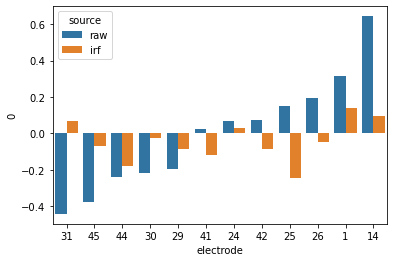

In [153]:
plot_df = pd.concat([electrode_ranks - electrode_ranks.mean(), irf_electrode_ranks], names=["source"], keys=["raw", "irf"])
sns.barplot(data=plot_df.reset_index(), x="electrode", y=0, hue="source")

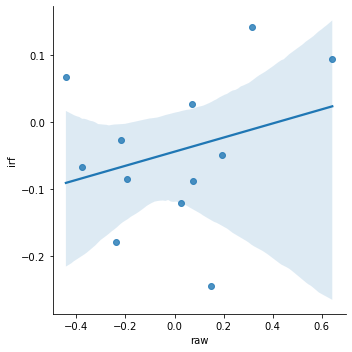

In [163]:
sns.lmplot(data=plot_df.unstack().T.reset_index(), x="raw", y="irf")

In [148]:
raw_to_plot = electrode_tertile_response_diffs["diff"]
raw_to_plot -= raw_to_plot.groupby("electrode").mean()

plot_df = pd.concat([raw_to_plot.reset_index("subject", drop=True),
                     cdrnn_irf_df["surprisal"].reset_index("run", drop=True)],
                    names=["source"], keys=["raw", "irf"])

<AxesSubplot:xlabel='electrode', ylabel='0'>

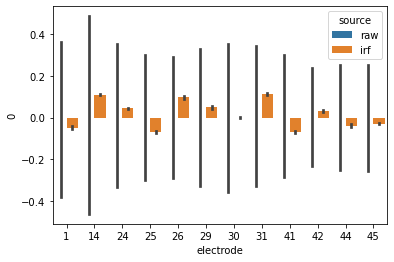

In [151]:
sns.barplot(data=plot_df.reset_index(), x="electrode", y=0, hue="source")

## Unrelated: generate fig for proposal

In [4]:
epochs = data.to_epochs(EPOCH_WINDOW)
all_dfs = pd.concat([e.to_data_frame() for e in tqdm(epochs.values())],
                    names=["subject"], keys=epochs.keys())

  0%|          | 0/24 [00:00<?, ?it/s]

In [5]:
id_vars = ["subject", "epoch", "time", "condition"]
plot_data = all_dfs.reset_index()[id_vars + N400_ELECTRODES[:2]] \
    .melt(id_vars=id_vars, var_name="electrode")

In [6]:
plot_data

,subject,epoch,time,condition,electrode,value
0,1,0,-100,155,1,-5.064854
1,1,0,-96,155,1,-4.090628
2,1,0,-92,155,1,-3.303122
3,1,0,-88,155,1,-3.012564
4,1,0,-84,155,1,-2.965765
...,...,...,...,...,...,...
16239515,24,1930,584,6,14,34.500541
16239516,24,1930,588,6,14,32.452838
16239517,24,1930,592,6,14,29.842494
16239518,24,1930,596,6,14,26.923469


<AxesSubplot:xlabel='time', ylabel='value'>

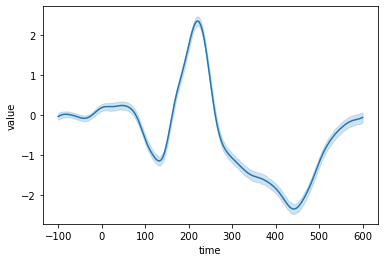

In [8]:
sns.lineplot(data=plot_data[plot_data.electrode == "1"], x="time", y="value")

In [10]:
avg = plot_data[plot_data.electrode == "1"].groupby("time").value.mean().reset_index()

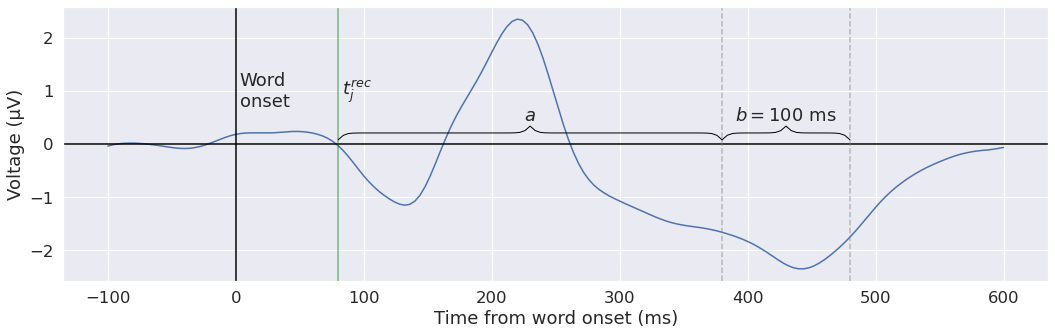

In [50]:
plt.subplots(figsize=(15, 5))
sns.set(font_scale=1.5)
ax = sns.lineplot(data=avg, x="time", y="value")

ax.axhline(0, color="black")
ax.axvline(0, color="black")
rec_point = 80
ax.axvline(rec_point, color="green", alpha=0.5)

window_left, window_right = 380, 480
ax.axvline(window_left, color="gray", alpha=0.5, linestyle="--")
ax.axvline(window_right, color="gray", alpha=0.5, linestyle="--")

def draw_brace(ax, xspan, yy, text):
    """Draws an annotated brace on the axes."""
    xmin, xmax = xspan
    xspan = xmax - xmin
    ax_xmin, ax_xmax = ax.get_xlim()
    xax_span = ax_xmax - ax_xmin

    ymin, ymax = ax.get_ylim()
    yspan = ymax - ymin
    resolution = int(xspan/xax_span*100)*2+1 # guaranteed uneven
    beta = 300./xax_span # the higher this is, the smaller the radius

    x = np.linspace(xmin, xmax, resolution)
    x_half = x[:int(resolution/2)+1]
    y_half_brace = (1/(1.+np.exp(-beta*(x_half-x_half[0])))
                    + 1/(1.+np.exp(-beta*(x_half-x_half[-1]))))
    y = np.concatenate((y_half_brace, y_half_brace[-2::-1]))
    y = yy + (.05*y - .01)*yspan # adjust vertical position

    ax.autoscale(False)
    ax.plot(x, y, color='black', lw=1)

    ax.text((xmax+xmin)/2., yy+.07*yspan, text, ha='center', va='bottom')

draw_brace(ax, (rec_point, window_left), 0, "$a$")
b = window_right - window_left
draw_brace(ax, (window_left, window_right), 0, f"$b = {b}$ ms")

ax.text(0 + 3, 1, "Word\nonset", va="center")
ax.text(rec_point + 3, 1, "$t_j^{rec}$", va="center")

ax.set_xlabel("Time from word onset (ms)")
ax.set_ylabel("Voltage (μV)")

plt.tight_layout()
plt.savefig("regression_example.svg", transparent=True)